In [1]:
import torch
from torch import nn
from torchinfo import summary
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

from going_modular.custom_data_setup_main_train import LoadDataset
from going_modular import engine, utils
from going_modular import custom_data_setup_pre_train
from going_modular.OneHeadModel import OneHeadModel
import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [ ]:
allow_train = True
EPOCHS = 20
BATCH_SIZE = 128
shrink_size = None

crop_size = 240

num_augs = 0
p_dropout = 0.3
lr = 1e-2
weight_deacay = 1e-5
T_max = 20
eta_min = 1e-5
momentum = 0.9
label_smoothing = 0.1

freeze_encoder = False

In [3]:
# Set matmul precision for TF32 usage on Ampere+ GPUs
# torch.set_float32_matmul_precision('medium')

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Augmentation

In [4]:
train_transforms = helper_functions.get_augmentation_train_transforms(num_augs, crop_size)
test_transforms = helper_functions.get_augmentation_test_transforms(crop_size)
no_transforms = helper_functions.get_augmentation_no_transforms(crop_size)

In [5]:
# load all dataloaders

train_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(
    transform=train_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

train_exp_dataloader, class_names = custom_data_setup_pre_train.create_train_dataloader(
    transform=test_transforms,
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

val_dataloader, class_names = custom_data_setup_pre_train.create_test_dataloader(
    transform=test_transforms, 
    batch_size=BATCH_SIZE,
    shrink_size=shrink_size) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2489083].


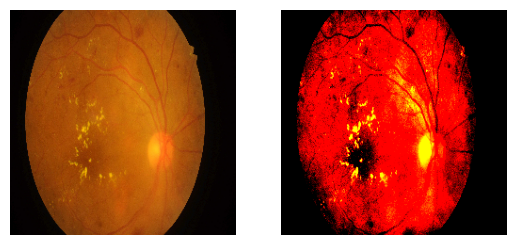

In [6]:
# plot some of the images to check applied augmentations

IDRID_image_folder = "../IDRID/Imagenes/Imagenes" 
IDRID_csv_file = "../IDRID/idrid_labels.csv"  

test_dataset_with_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=train_transforms)
test_dataset_no_transform = LoadDataset(IDRID_image_folder, IDRID_csv_file, transform=no_transforms)

for i in range(1):
    img_2 = test_dataset_with_transform[i][0].permute(1, 2, 0)
    img_1 = test_dataset_no_transform[i][0].permute(1, 2, 0)
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(img_1.numpy())
    axes[1].imshow(img_2.numpy())
    axes[0].axis(False)
    axes[1].axis(False)
    plt.show()

In [7]:
model = OneHeadModel(device=device, p_dropout=p_dropout).to(device)

In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
if freeze_encoder:
    for param in model.encoder.parameters():
        param.requires_grad = False

In [9]:
# Print a summary using torchinfo (uncomment for actual output)
torch.manual_seed(33)
summary(
model=model, 
input_size=(32, 3, crop_size, crop_size), # make sure this is "input_size", not "input_shape"
col_names=["input_size", "output_size", "num_params", "trainable"],
col_width=20,
row_settings=["var_names"]) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
OneHeadModel (OneHeadModel)                                  [32, 3, 240, 240]    [32, 5]              --                   True
├─Sequential (encoder)                                       [32, 3, 240, 240]    [32, 1280, 8, 8]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 240, 240]    [32, 32, 120, 120]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 240, 240]    [32, 32, 120, 120]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 120, 120]   [32, 32, 120, 120]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 120, 120]   [32, 32, 120, 120]   --                   --
│    └─Sequential (1)                                        [32, 32, 120, 120]   [32, 16, 120

In [10]:
# Define loss and optimizer

# weight = torch.tensor([1/1805, 1/370, 1/999, 1/193, 1/295]) * 500 
# weight.to(device)

# loss_fn_classification = nn.CrossEntropyLoss(weight=weight, label_smoothing=0.1).to(device)
loss_fn_classification = nn.CrossEntropyLoss(label_smoothing=label_smoothing).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_deacay, momentum=momentum, nesterov=True)

from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2)

# scheduler = CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

In [ ]:
# model = torch.compile(model)

train_results = []

if allow_train:
    # Set the random seeds
    torch.manual_seed(1404)
    torch.cuda.manual_seed(1404)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    train_results, val_results = engine.train(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        optimizer=optimizer,
        scheduler=scheduler,
        loss_fn_classification=loss_fn_classification,
        epochs=EPOCHS,
        device=device)
        
    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='pre_train_model.pth')
else:
    model.load_state_dict(torch.load('models/pre_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/2 [00:00<?, ?it/s]

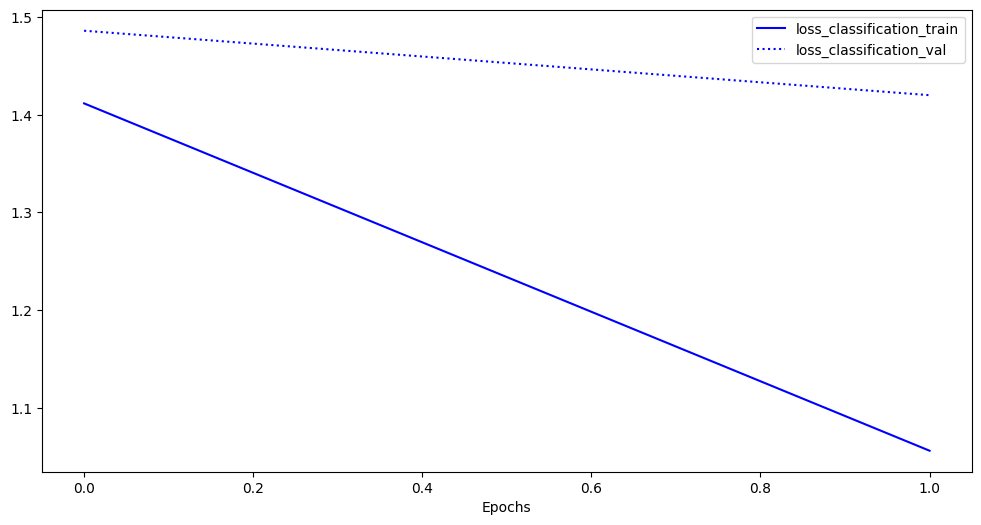

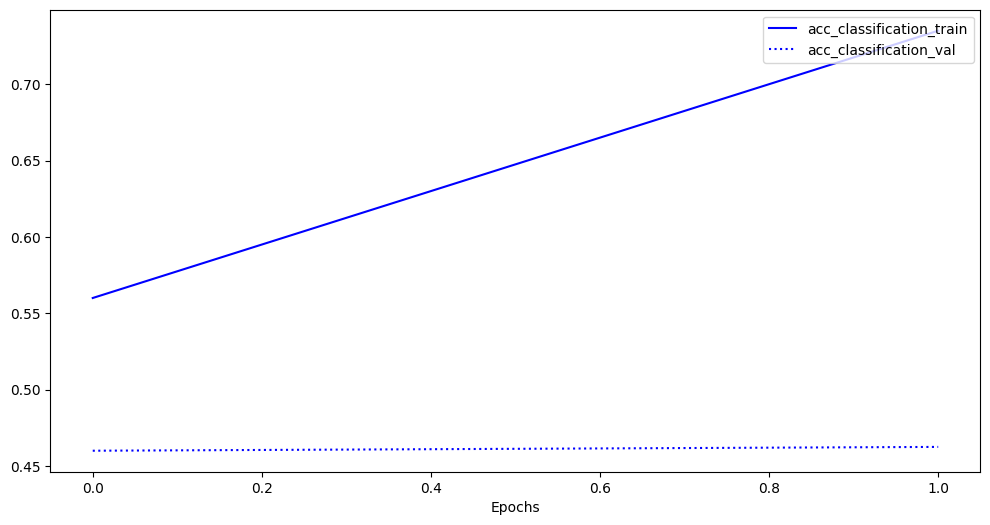

In [ ]:
if allow_train:
    helper_functions.plot_loss_curves(train_results, val_results)
    helper_functions.plot_acc_curves(train_results, val_results)

per class precision: [0.47493404 0.         0.35       0.         0.        ]
per class recall: [0.96774194 0.         0.06086957 0.         0.        ]
per class f1_score: [0.63716814 0.         0.1037037  0.         0.        ]
average scores >>> precision: 0.16498680738786278 | recall: 0.20572230014025247 | f1_score: 0.14817436905932482
accuracy: 0.4675
QWK:  0.03302377878649054


c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


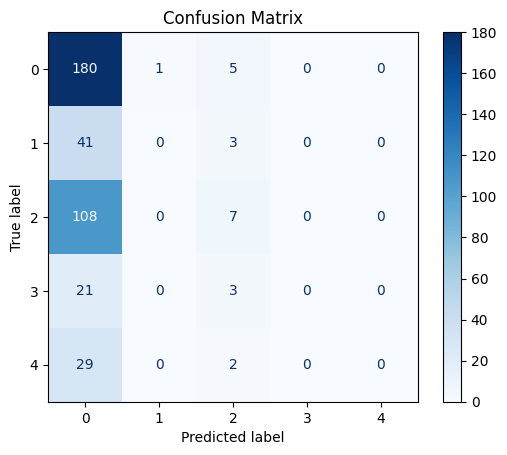

In [ ]:
# results is for APTOS-2019

test_results = engine.test_step(
    model=model,
    dataloader=val_dataloader,
    device=device)

per class precision: [0.77105263 0.         0.70588235 0.         1.        ]
per class recall: [0.98986486 0.         0.21052632 0.         0.2       ]
per class f1_score: [0.86686391 0.         0.32432432 0.         0.33333333]
average scores >>> precision: 0.4953869969040248 | recall: 0.2800782361308677 | f1_score: 0.30490431259662026
accuracy: 0.77
QWK:  0.23681114255731872


c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


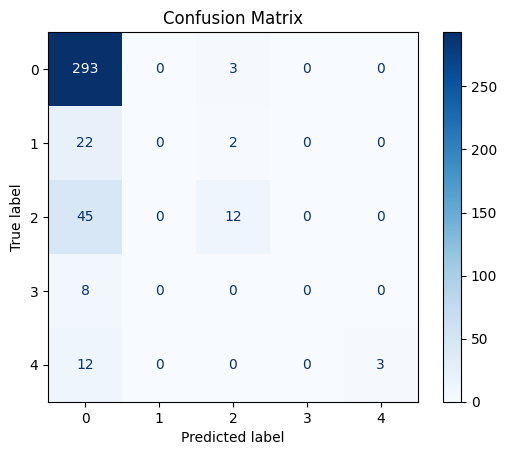

In [ ]:
# results is for APTOS-2015

test_results = engine.test_step(
    model=model,
    dataloader=train_exp_dataloader,
    device=device)

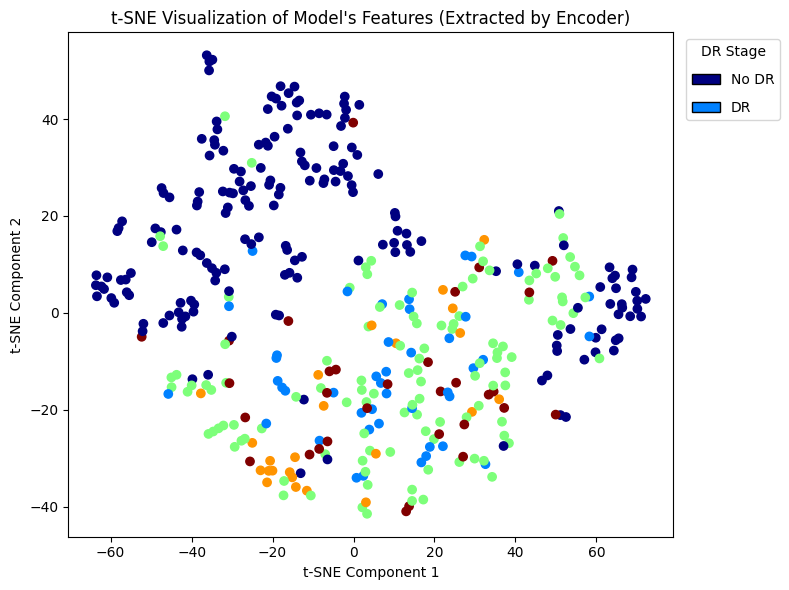

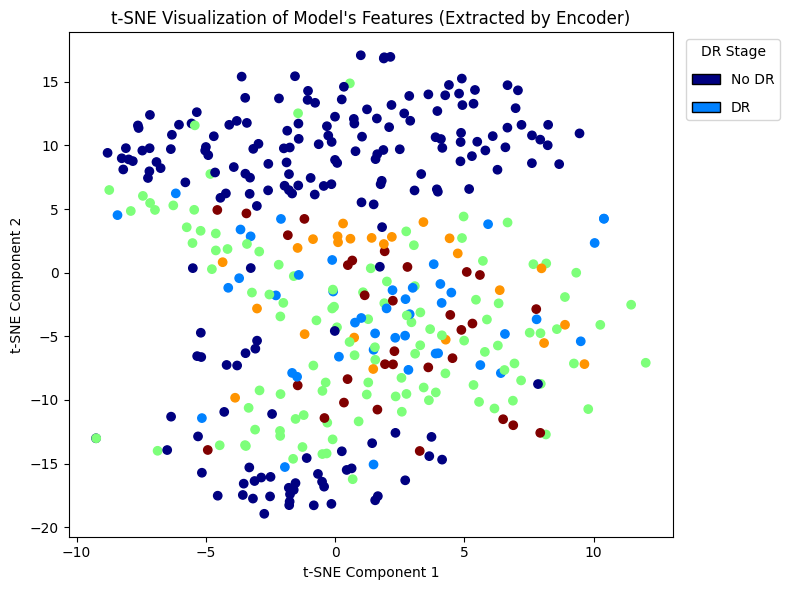

In [ ]:
helper_functions.plot_t_SNE(model=model,
                        dataloader=val_dataloader,
                        perp_vals=[5, 40],
                        NUM_ITER=2000)